In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import importlib.util
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import os
from crashpy.utilities import crashMemMap
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
def place_fesc(fesc_arr, threshold=1e-3):
    frac_small = (fesc_arr < threshold).sum()/len(fesc_arr)
    
    fesc_new = np.zeros_like(fesc_arr)
    for i, fesc in enumerate(fesc_arr):
        if fesc < threshold:
            fesc_new[i] = 1.5*threshold+np.random.uniform(-0.5*threshold, 0.5*threshold) 
        else:
            fesc_new[i] = fesc
    return frac_small, fesc_new

In [3]:
def get_scatter(df, prop, x_prop='StarMass', bin_width=0.1, mode='median', threshhold=1e-3, relative=False):
    
    f_esc = df.loc[:,'f_esc']
    x_values = df.loc[:,x_prop]
    if bin_width==None:
        prop_norm = {}

        prop_norm[prop]=[]
        column = df[prop]
        if mode == 'median':
            norm_val = column.median()
        elif mode == 'mean':
            norm_val = column.mean()
        if relative:
            new_data=column/norm_val
        else:
            new_data=column-norm_val
        prop_norm[prop].extend(new_data)
        prop_norm[prop] = np.array(prop_norm[prop])
        return x_values, f_esc, prop_norm
        
    
    x_values_log = np.log10(x_values)
    log_edges = np.arange(x_values_log.min(), x_values_log.max(), bin_width)
    edges = np.power(10, log_edges)
    prop_norm = {}
    prop_norm[prop]=np.zeros(df[x_prop].size, dtype='float32')
    start_index = 0
    end_index = 0
    for i in range(len(edges)-1):
        column = df[(edges[i]*(1-1e-10)<df[x_prop]) & (df[x_prop]<edges[i+1])][prop]
        end_index += len(column)
        if mode == 'median':
            norm_val=column.median()
        elif mode == 'mean':
            norm_val=column.mean()
        if relative:
            #print(norm_val)
            new_data=column/norm_val
        else:
            new_data=column-norm_val

        prop_norm[prop][start_index:end_index] = new_data
        start_index=end_index
    prop_norm[prop] = np.array(prop_norm[prop])
    return x_values, f_esc, prop_norm

In [29]:
def plot_scatter_color(df, prop, x_prop='StarMass', bin_width=0.1, mode='median', threshold=1e-3, label=None, relative=False, log=False, save = False):
        
    x_labelsize = 50
    y_labelsize = 50

    length_major_ticks = 16
    length_minor_ticks = 8
    width_minor_ticks = 3
    width_major_ticks = 4
    labelsize_x_ticks = 35
    labelsize_y_ticks = 35
    
    marker_size = 45
    colorbar_labelsize = 50
    colorbar_ticklabelsize = 35
    
    axes_width = 3
    
    figure_width = 20
    figure_height = 20
    
    if relative:
#         v_min=0.5
#         v_max=2.0
        v_min = 0.8
        v_max = 1.2
        v_center=1.0
    else:
        v_min=None
        v_max=None
        v_center=None
    
    if log:
        v_min=-0.3
        v_max=0
        v_center=0.3
    
    if x_prop == 'HaloMass':
        mult = 1e10
        x_label = 'Halo Mass [$\log(M_{\mathrm{sun}})$]'
    elif x_prop == 'StarMass':
        x_label = 'Stellar Mass [$\log(M_{\mathrm{sun}})$]'
    else:
        raise ValueError("Only defined for the properties 'HaloMass' and 'StarMass'")
    

    df.sort_values(by=x_prop, inplace=True)
    x_values, f_esc, prop_norm = get_scatter(df, prop=prop, x_prop=x_prop, bin_width=bin_width, mode=mode, threshhold=threshold, relative=relative)
    
    y_axis = 'f_esc' 
    y_label = '$f_\mathrm{esc}$'

    frac_small, f_esc_plot = place_fesc(f_esc, threshold)
    
    f, ax = plt.subplots()
    
    if log:
        color_data = np.log10(prop_norm[prop])
        if label == None:
            bar_label = f'$\log(\Delta ${prop})'
        else:
            bar_label = label
    else:
        color_data = prop_norm[prop]
        if label == None:
            bar_label = f'$\Delta ${prop}'
        else: 
            bar_label = label

    col_norm = colors.DivergingNorm(vmin=v_min, vcenter=v_center, vmax=v_max)
    subfig = ax.scatter(np.log10(x_values), f_esc_plot, c=color_data, norm=col_norm, cmap=plt.get_cmap('coolwarm'), zorder=-20, s=marker_size)
    ax.set_yscale('log')
    ax.set_ylim(threshold,1.)
    ax.set_xlabel(x_label, size=x_labelsize)
    ax.set_ylabel(y_label, size=y_labelsize)
    
    # Save the scatter as a rasterization graphic to make the plots smaller
    ax.set_rasterization_zorder(-15)

    ax.tick_params(length=length_major_ticks, width=width_major_ticks)
    ax.tick_params(length=length_minor_ticks, width=width_minor_ticks, which='minor')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = f.colorbar(subfig, cax=cax)
    cbar.set_label(bar_label, size=colorbar_labelsize)
    cbar.ax.tick_params(labelsize=colorbar_ticklabelsize)

    xticklabels = ax.get_xticklabels()
    plt.setp(xticklabels, visible=True)
    plt.rc('axes', linewidth=axes_width)
    plt.rc('xtick', labelsize=labelsize_x_ticks) 
    plt.rc('ytick', labelsize=labelsize_y_ticks) 
    
    plt.rcParams["figure.figsize"] = (figure_width,figure_height)
    plt.tight_layout(rect=(0,0,1,0.7))
    
    if save:
        if bin_width==None:
            filename = f'/u/ivkos/analysis/plots/{x_prop}_scatter_{prop}_nobinning.pdf'
        else:
            filename = f'/u/ivkos/analysis/plots/scatter_plots/{prop}_scatter.pdf'
        plt.savefig(filename, bbox_inches = 'tight')
    plt.show();
    return

In [5]:
def lum_str_to_float(string):
    string = string.replace('d', 'e')
    return float(string)

In [6]:
def source_dist_lum(ID, redshift, conf, side_length, r_v):
    snap = redshift_to_snap(redshift)
    path_sources = f'/ptmp/mpa/mglatzle/TNG_f_esc/{conf}/run/L35n2160TNG/{snap}/g{ID}/Input/sources_ic00.in'
    
    # 0.5 is needed to take into account that the sources are at the center of the grid voxel, move origin to halo center
    coord = pd.read_csv(path_sources, delim_whitespace=True, header=None, usecols=[0,1,2])+0.5-side_length/2
    lum = pd.read_csv(path_sources, delim_whitespace=True, header=None, usecols=[3])
    dist = np.sqrt(np.sum(coord**2, axis=1))*2/side_length

    dist_lum_df = pd.DataFrame({'dist':dist,'lum':lum[3]})
    dist_lum_df.sort_values('dist', inplace=True)

    return dist_lum_df

In [7]:
def mass_dens_r(dist_lum_df, frac, r_v):
    lum = np.vectorize(lum_str_to_float)(dist_lum_df['lum'])
    sorted_dist = np.array(dist_lum_df['dist'])
    frac_lum = frac*lum.sum()
    
    radius_idx = 0
    tot_lum = 0.
    while tot_lum <= frac_lum:
        prev_lum = tot_lum
        tot_lum += lum[radius_idx]
        radius_idx += 1
        
    contribution_idx1 = (tot_lum-frac_lum)/(tot_lum-prev_lum)
    contribution_idx2 = 1-contribution_idx1
    
    r_frac = contribution_idx1*sorted_dist[radius_idx-2]+contribution_idx2*sorted_dist[radius_idx-1]
    return r_frac

In [8]:
def update_mass_rad(df, frac, conf):
    radii = []
    new_column_name = f'r_mass_{int(frac*100)}'
    for index, row in df.iterrows():
        dist_lum_df = source_dist_lum(ID=row.ID, redshift=row.z, conf=conf, side_length=row.GridSize, r_v=row.HaloRadii)
        r_frac = mass_dens_r(dist_lum_df=dist_lum_df, frac=frac, r_v=row.HaloRadii)
        radii.append(r_frac)
    df[new_column_name] = radii

In [9]:
def redshift_to_snap(redshift):
    snapnames = {6:'sn013', 8:'sn008', 10:'sn004'}
    return snapnames[redshift]

In [10]:
h=0.6774
def update_df(df):
    df['Q0/HaloMass']=df['Q0']/df['HaloMass']
    df['avg_dens']=df['HaloMass']*3/(df['HaloRadii']**3*4)
    df['StarMass']= df['HaloMass']*df['FractionStars']*1e10/h
    df['SFR/StarMass']= df['SFR']*df['StarMass']/1e4
    df['M_star_M_gas'] = df['FractionStars']/df['FractionGas']
    df['M_dust_M_gas'] = df['FractionDust']/df['FractionGas']
    return

In [11]:
def add_relative_mass_r(df, mass_r_frac):
    df[f'R_M,{int(frac*100)}']=df['HaloRadii']/df[f'r_mass_{int(frac*100)}']
    df['avg_halo_dens'] = 3*df['HaloMass']/(4*np.pi*df['HaloRadii']**3)
    return

In [12]:
df = pd.read_pickle('dfs/full_esc_updated.pickle')
frac = 0.5
update_mass_rad(df, frac,'fid2')
update_df(df)
add_relative_mass_r(df, frac)

In [13]:
update_df(df)

In [14]:
props = [ 'HaloRadii', 'HaloMass', 'clumping', 'Q0','avg_dens', 'r_mass_50', 'avg_halo_dens',
         'Metallicity','FractionGas', 'FractionDust', 'clump_gas', 'sigma_gas_gal', 'sigma_star_gal', 'SFR'
        ]

In [15]:
prop_label = {
    'clumping':r'$C_\mathrm{halo}$', 
    'Q0':r'$Q_0$', 
    'HaloRadii':r'$R_\mathrm{vir}$', 
    'HaloMass':r'$M_\mathrm{vir}$', 
    'avg_dens':r'$\bar{\rho}$', 
    'avg_halo_dens':r'$\bar{\rho}$',
    'r_mass_50':r'$R_{\frac{1}{2}\mathrm{star}}$',
    'Metallicity':r'$Z$',
    'FractionGas':r'$f_\mathrm{gas}$', 
    'FractionDust':r'$f_\mathrm{dust}$', 
    'clump_gas':r'$C_\mathrm{galaxy}$', 
    'sigma_gas_gal':r'$\Sigma_\mathrm{gas}$', 
    'sigma_star_gal':r'$\Sigma_\mathrm{star}$', 
    'SFR':'SFR',
    'M_star_M_gas':r'$M_\mathrm{star}/M_\mathrm{gas}$',
    'M_dust_M_gas':r'$M_\mathrm{dust}/M_\mathrm{gas}$'
}

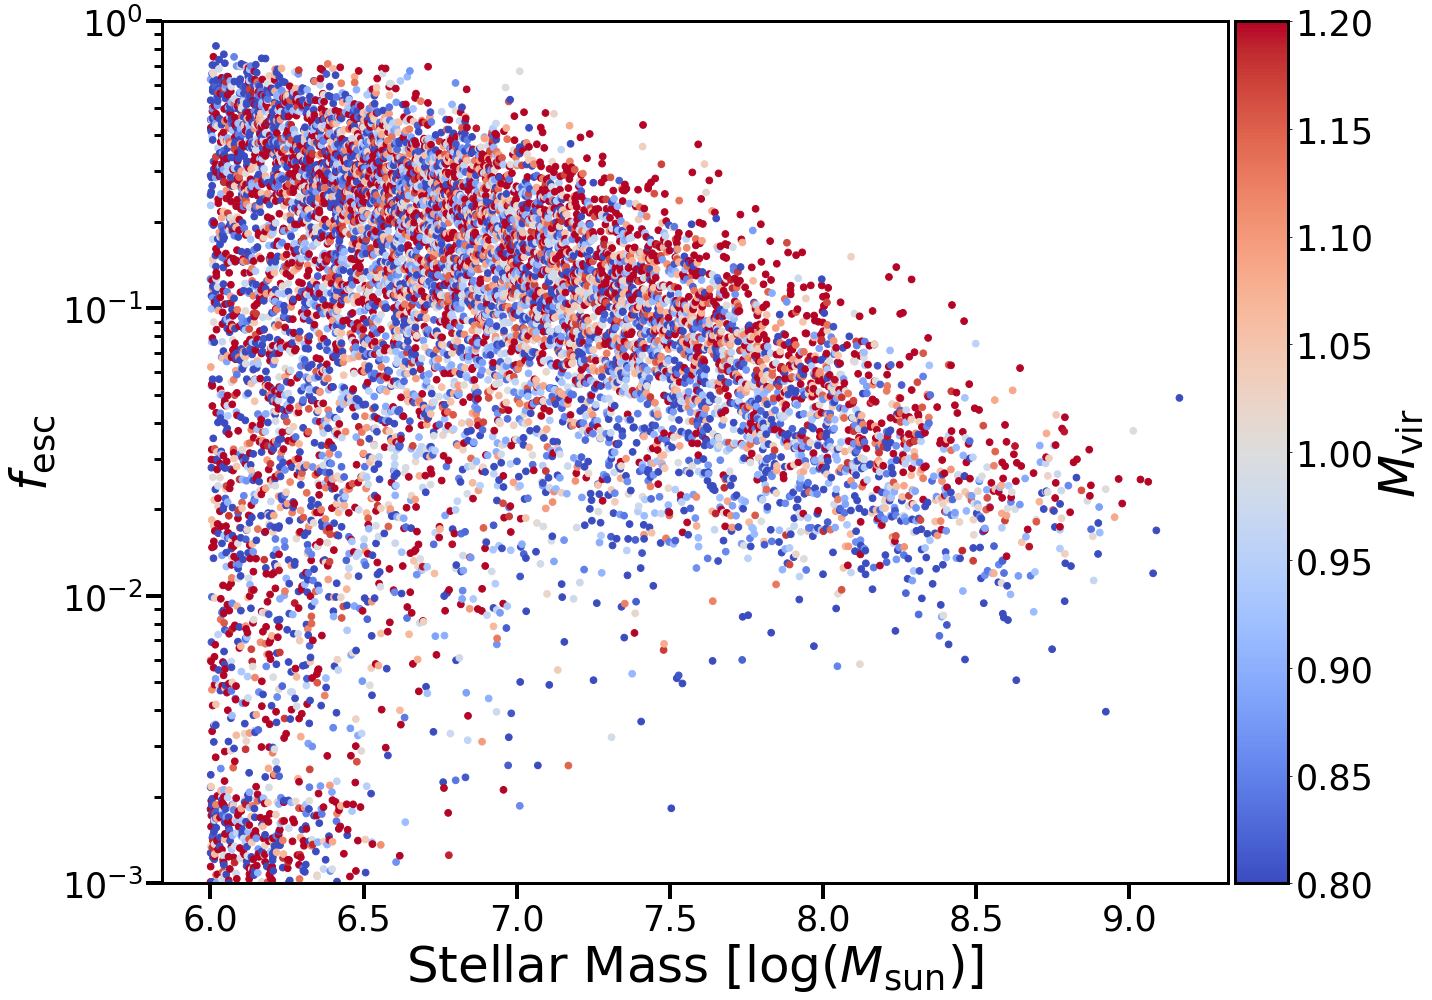

In [31]:
#for prop in props:
prop = 'HaloMass'
plot_scatter_color(df, prop=prop, x_prop='StarMass', bin_width=0.1, 
                   mode='median', threshold=1e-3, label=prop_label[prop], relative=True, log=False, save=True)

In [23]:
import numpy as np
from matplotlib import pyplot as plt

In [143]:
df.keys()

Index(['ID', 'z', 'HaloMass', 'Metallicity', 'FractionStars', 'FractionGas',
       'FractionDust', 'Q0', 'HaloRadii', 'f_esc', 'f_esc_0_2', 'Temperature',
       'xHII', 'xHeII', 'xHeIII', 'GridSize', 'BHMass', 'BHGrowth', 'SFR',
       'density', 'clumping', 'per_freq', 'per_source', 'emitted_photons',
       'escaped_photons', 'frequencies', 'n_iterations', 'per_freq_0_2',
       'per_source_0_2', 'emitted_photons_0_2', 'escaped_photons_0_2',
       'frequencies_0_2', 'n_iterations_0_2', 'Q0/HaloMass', 'R_v^3/HaloMass',
       'StarMass', 'StellarAges', 'r_mass_50', 'avg_dens', 'SFR/StarMass',
       'R_M,50'],
      dtype='object')

In [88]:
df[(df['Q0']>8.103099029439979e+53)&(df['Q0']<8.203099029439979e+53)][['Q0','z']]

,Q0,z
1406,8.130730e+53,8
122,8.132872e+53,6


In [153]:
np.array(df[df.z==6]['ID'][700:730])

array([2900, 1984, 3081, 2824, 3379, 1529, 2413, 2212, 2846, 3930, 3837,
       2259, 3622, 2772, 2829, 2886, 2269, 2858, 2154, 4124, 2170, 2082,
       3102, 2153, 1760, 3419, 2822, 4309, 2136, 2247])

In [142]:
5.645720278833696e+46/8.130730e+53

6.94368190658612e-08

In [136]:
df.keys()

Index(['ID', 'z', 'HaloMass', 'Metallicity', 'FractionStars', 'FractionGas',
       'FractionDust', 'Q0', 'HaloRadii', 'f_esc', 'f_esc_0_2', 'Temperature',
       'xHII', 'xHeII', 'xHeIII', 'GridSize', 'BHMass', 'BHGrowth', 'SFR',
       'density', 'clumping', 'per_freq', 'per_source', 'emitted_photons',
       'escaped_photons', 'frequencies', 'n_iterations', 'per_freq_0_2',
       'per_source_0_2', 'emitted_photons_0_2', 'escaped_photons_0_2',
       'frequencies_0_2', 'n_iterations_0_2', 'Q0/HaloMass', 'R_v^3/HaloMass',
       'StarMass', 'StellarAges', 'r_mass_50', 'avg_dens', 'SFR/StarMass',
       'R_M,50'],
      dtype='object')

In [159]:
df.loc[122]['emitted_photons'].sum()/1000/df.loc[122]['n_iterations']*1e52

8.091885973880005e+53

In [138]:
df.loc[122]['per_freq']

array([0.00844469, 0.00831696, 0.00817659, 0.00820562, 0.00834503,
       0.00842349, 0.00840187, 0.00843004, 0.00863983, 0.00887272,
       0.00911665, 0.00953418, 0.0098723 , 0.01015504, 0.01031941,
       0.0108683 , 0.01146904, 0.01226345, 0.01272612, 0.01275194,
       0.01372645, 0.01485126, 0.01572888, 0.01666371, 0.01823537,
       0.01967958, 0.02178292, 0.02348021, 0.02394722, 0.0110251 ,
       0.01105097, 0.01066853, 0.01096355, 0.01163137, 0.01221532,
       0.01308852, 0.01420743, 0.01616827, 0.01945316, 0.02250231,
       0.02580354, 0.03142027, 0.0389153 , 0.04988485, 0.06384143,
       0.00078621, 0.00092173, 0.00121999, 0.00128745, 0.0013652 ,
       0.00145695, 0.00160763, 0.0016425 , 0.00170013, 0.00196367,
       0.00244732, 0.00304554, 0.00336282, 0.00384474, 0.0045021 ,
       0.0048586 , 0.00643391, 0.01080167, 0.02316907, 0.04839103])

In [144]:
np.dot(energies,emitted).sum()*1e7/df.loc[122]['n_iterations']
np.dot(energies,emitted).min()

2.822860139416848e+46

0.0

In [120]:
(emitted[:, 0]*energies)

array([9.93269194e-23, 2.05068683e-22, 3.51252005e-22, 5.51934271e-22,
       7.98079783e-22, 1.08739168e-21, 1.41646268e-21, 1.79498795e-21,
       2.22047224e-21, 2.66574879e-21, 3.15462986e-21, 3.70540363e-21,
       4.29239958e-21, 4.86677960e-21, 5.51631193e-21, 6.20514360e-21,
       5.52527139e-21, 6.02041762e-21, 8.24666541e-21, 9.13925187e-21,
       9.34589227e-21, 9.72879374e-21, 1.04383757e-20, 1.03909813e-20,
       9.74366118e-21, 9.49585678e-21, 8.92126231e-21, 8.91255729e-21,
       1.00251540e-20, 2.11874078e-22, 8.31973398e-22, 1.90054723e-21,
       3.19096043e-21, 4.78793344e-21, 6.53271531e-21, 7.17465374e-21,
       6.27678532e-21, 4.89540934e-21, 4.70495690e-21, 5.70276593e-21,
       5.15696519e-21, 3.81060413e-21, 3.19665313e-21, 2.10086323e-21,
       4.75331258e-24, 1.84145566e-23, 4.01331267e-23, 6.89021432e-23,
       1.01497885e-22, 1.36829801e-22, 1.78135928e-22, 2.13472200e-22,
       2.50077808e-22, 2.84759012e-22, 2.90766179e-22, 2.78168104e-22,
      

In [124]:
energies/(1.6e-19)

array([ 13.56544984,  13.57298415,  13.58747321,  13.61123507,
        13.64658818,  13.69585078,  13.76134155,  13.84537873,
        13.95027996,  14.07836389,  14.23194878,  14.41335246,
        14.62489339,  14.86888982,  15.14766021,  15.4635228 ,
        15.81879544,  16.21579658,  16.65684488,  17.14425838,
        17.68035514,  18.26745381,  18.90787202,  19.60392885,
        20.35794214,  21.17222972,  22.04911067,  22.99090262,
        23.99992547,  24.53352371,  24.59346883,  24.74932577,
        25.04905033,  25.54059956,  26.27192968,  27.29099526,
        28.64575271,  30.38415868,  32.55416856,  35.20373938,
        38.38082676,  42.13338566,  46.50937294,  51.55674563,
        54.26456681,  54.31604062,  54.44987625,  54.70724944,
        55.12934006,  55.75733006,  56.63239931,  57.79572563,
        59.28848681,  61.15186688,  63.42704569,  66.155199  ,
        69.37750669,  73.13515481,  77.46932738,  80.23434994,
        82.47764456,  88.31021925,  99.52670475, 117.92

In [97]:
h_planck = 6.6e-34

In [101]:
energies = df.loc[122]['frequencies']*h_planck

In [20]:
widths = []
for i in range(len(freq)-1):
    widths.append(freq[i+1]-freq[i])
widths.append(freq[-1]-freq[-2])
widths = np.array(widths)
widths = widths/(widths[-1]-widths[0])

In [30]:
from scipy.integrate import trapz
print(trapz(amp, x=freq)/(freq[-1]-freq[0]))

0.019048087594544922


In [160]:
df.columns

Index(['ID', 'z', 'HaloMass', 'Metallicity', 'FractionStars', 'FractionGas',
       'FractionDust', 'Q0', 'HaloRadii', 'f_esc', 'f_esc_0_2', 'Temperature',
       'xHII', 'xHeII', 'xHeIII', 'GridSize', 'BHMass', 'BHGrowth', 'SFR',
       'density', 'clumping', 'per_freq', 'per_source', 'emitted_photons',
       'escaped_photons', 'frequencies', 'n_iterations', 'per_freq_0_2',
       'per_source_0_2', 'emitted_photons_0_2', 'escaped_photons_0_2',
       'frequencies_0_2', 'n_iterations_0_2', 'Q0/HaloMass', 'R_v^3/HaloMass',
       'StarMass', 'StellarAges', 'r_mass_50', 'avg_dens', 'SFR/StarMass',
       'R_M,50'],
      dtype='object')

In [22]:
np

6.032262648686729